# Project 2: Uncles and Uncles Rewards
- Model a Blockchain that uses uncles and uncle rewards
- Model rewarding mechanism to reward uncle block creators
- Model selfish mining (only one attacker) in this blockchain

Try to answer the following questions with your experiment:
1. How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles.
2. What is the impact of uncles on selfish mining? Is selfish mining more profitable with uncles?
3. What does it mean in this model for the selfish mining attack to be profitable?

 Since more miners will get rewards for mining, even if they don't finish a block that is part of the longest chain, they will be rewarded for it. So the time and energy used for that block will not be as wasted, and it seems more rewarding to mine. Show net money with and without uncle rewards to display point. The concept of it is for fairness, but may encourage selfish mining. 

### Imports

In [317]:
#Import statements
from draw_blockchain import show
import hashlib as hasher
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from dataclasses import dataclass
import functools
import operator
import pandas as pd

### Hash function

In [318]:
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    #print(type(inputbytes))
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

### Block

In [319]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0, blockchain=None):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0", blockchain, genesis=True)
            self.height = 0
            self.color = "#AEF751"
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
            self.color = creator.color
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data + self.creator.name + self.previous_hash + str(self.nonce))

    def print(self):
        print(self.data + " "+ self.creator.name + " " + str(self.height))

### Blockchain

In [320]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, blockReward=10, static=False):
        self.chain = []
        self.difficulty = difficulty
        self.size = 0
        self.block_reward = blockReward
        self.uncles = []
        self.static = static
        self.chain.append(Block(genesis_data, blockchain=self))

    def longestChain(self, static=-1):
      max = self.chain[0].height
      for block in self.chain:
          if block.height > max:
                max = block.height
      maxes = [block for block in self.chain if block.height == max]
      static %= len(maxes)
      r = maxes[static:static+1] if static >= 0 else random.choices(maxes, k=1)
      return r[0]
    
    def ends_with_fork(self):
        max = self.chain[0].height
        r = False
        for block in self.chain:
            if block.height == max: r = True
            if block.height > max:
                max = block.height
                r = False
        return r
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        # if self.inlongestChain(newBlock):
        #     newBlock.creator.reward += self.block_reward
        # else:  
        #     self.uncles.append(newBlock)
        
    def print(self):
        for block in self.chain:
            block.print()
            print("________")

    def hasFork(self):
        for block1 in self.chain:
            for block2 in self.chain:
                if block1!=block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
      last = self.longestChain(miner.static)
      count = 0
      while last!=None:
          if last.creator == miner:
                count += 1
          last = last.previous
      return count
    
    def inlongestChain(self, block):
          last = self.longestChain()
          while last!= None:
                if last == block: #need more of a check for if fork
                        # print("last",last.height,"block", block.height)
                        return True
                last = last.previous
          return False
          
    #Think this one works but not 110% sure yet
    def forks(self):
        fork_list = []
        last = self.longestChain()
        while last != None:
            # print(last.creator.name)
            for child in last.children:
                if not self.inlongestChain(child):
                    length = 1
                    forkblock = child
                    while forkblock.children:
                        length += 1
                        forkblock = forkblock.children[0]
                    fork_list.append(length)
            last = last.previous
        return fork_list


## Miners

### Normal miner

In [321]:
class Miner:
    def __init__(self, miningPower, name, blockchain=None, genesis=False):
        self.miningPower = miningPower
        self.nonce = 0 if blockchain.static else random.randint(0,100000) #original one
        # self.nonce = 0
        self.name = name
        self.blockchain = blockchain
        self.reward = 0
        self.uncle_reward = 0
        self.color = "#7EDBF6"
        self.uncles = 0
        self.nephews = 0
        self.blocks = 0
        self.static = sum([ord(c) for c in name]) if blockchain.static else -1
        if self.blockchain != None and not genesis:
            self.lastBlock = blockchain.longestChain(static=self.static)
    
    def UpdateLast(self):
        latest = self.blockchain.longestChain(static=self.static)
        if latest.height > self.lastBlock.height:
              self.lastBlock = latest

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1


### Selfish miner

In [322]:

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False
        self.color = "#F59AEE"

    def UpdateLast(self):
        #add this function
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        #add this function
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= self.blockchain.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

## Main program

### Run function

In [323]:
#Main
def run(
        reward=10, uncle_reward=0, nephew_reward=0,
        difficulty=10,
        num_miners=10,
        num_selfish_miners=0,
        mining_power=10,
        mining_power_selfish=15,
        genesis_data="0",
        num_blocks = 30,
        miners = [],
        static=False
    ):
    bc = None
    bc = Blockchain(genesis_data , difficulty, reward, static)
    miners = [Miner(p, "m"+ str(i), bc) for i,p in enumerate(miners)]
    selfish = []
    len_miners = len(miners)
    for i in range(num_miners):
        miners.append(Miner(mining_power ,"m"+str(len_miners+i), bc))
    for i in range(num_selfish_miners):
        selfish.append(SelfishMiner(mining_power_selfish ,"s"+str(i), bc))
    while bc.chain[-1].height < num_blocks or bc.ends_with_fork():
        for s in selfish:
            s.PoWSolver()

        for m in miners:
            m.PoWSolver()

        for s in selfish:
            s.UpdateLast()

        for m in miners:
            m.UpdateLast()
    last_block = bc.chain[-1]
    while last_block.previous is not None:
        last_block.creator.reward += reward
        last_block.creator.blocks += 1
        if uncle_reward > 0:
            grandparent = last_block.previous.previous
            if grandparent is not None and len(grandparent.children) > 1:
                for uncle in grandparent.children:
                    if uncle != last_block.previous:
                        uncle.creator.uncle_reward += uncle_reward
                        uncle.creator.uncles += 1
                        last_block.creator.uncle_reward += nephew_reward
                        last_block.creator.nephews += 1
        last_block=last_block.previous
    return bc, miners, selfish

def print_run(bc, miners, selfish):
    print("Has fork:", bc.hasFork())
    longest_chain = bc.longestChain()
    print("Longest chain height:",longest_chain.height)
    selfish_power = 0
    for s in selfish:
        selfish_power+=s.miningPower
        print(s.name, bc.checkMiner(s))
        print("Fraction {}".format(bc.checkMiner(s) /longest_chain.height ))
    total = selfish_power
    for m in miners:
        total += m.miningPower
    print("alpha {}".format(selfish_power / total))
    for m in miners:    
        print(m.name ,m.reward)
    for s in selfish:    
        print(s.name ,s.reward)
        

In [324]:

# show(bc)
# miner_rewards_avg = [0]*20
# miner_names_avg = []
# for i in range(10):
#     bc, m, s = run(num_miners=20, num_blocks=1000)
    # for mi in range(0,len(m)):
        # print(miner_rewards_avg,"avg")
        # print(m[mi])
        # miner_rewards_avg[mi] += m[mi].reward
# miner_rewards_avg[:] = [x / 10 for x in miner_rewards_avg]
    
# bc, m, s = run(num_miners=20, num_blocks=1000)

# miner_rewards = []
# for miners in m:
#     miner_rewards.append((miners.reward))
# miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards_avg)]
# plt.bar(miner_names,miner_rewards_avg)
#Need this for testing later :))

In [325]:
# def getRewards(miners):
#     miner_rewards = []
#     for m in miners:
#         miner_rewards.append(m.reward)
#     miner_names = ["m"+ str(i) for i, _ in enumerate(miner_rewards)]
#     return miner_names, miner_rewards


@dataclass
class Stats:
    name: str
    reward: int
    uncle_reward: int
    blocks: int
    uncles: int
    newphes: int
    power: int

# Transform irregular 2D list into a regular one.
def transform(nested_list):
    regular_list = []
    for e in nested_list:
        if type(e) is list:
            regular_list.append(e)
        else:
            regular_list.append([e])
    return functools.reduce(operator.iconcat, regular_list, [])

def get_stats(*miners):
    if len(miners) == 0:
        return []
    stats = []
    transformed_miners = transform(miners)
    
    for m in transformed_miners:
        stats.append(Stats(
            m.name,
            m.reward,
            m.uncle_reward,
            m.blocks,
            m.uncles,
            m.nephews,
            m.miningPower
        ))
    return pd.DataFrame(stats)

### Average function
Function to do multiple runs of simulation

In [326]:
def getavg(tests, run_func, **kwargs):
    args = set(kwargs)
    num_nodes = 0
    if "num_blocks" in kwargs:
        miner_args = {"num_miners","miners","num_selfish_miners"}.intersection(args)
        if miner_args:
            for arg in miner_args:
                val = kwargs.get(arg)
                num_nodes += len(val) if type(val) == list else val
        miner_rewards_avg = [0]*num_nodes
        miner_rewards_avg_uncles = [0]*num_nodes
        for i in range(tests):
            bc, m, s = run_func(**kwargs)
            # df = get_stats(m,s)
            for mi, miner in enumerate(m + s):
                miner_rewards_avg[mi] += miner.reward 
                miner_rewards_avg_uncles[mi] += miner.uncle_reward + miner.reward
        miner_rewards_avg[:] = [x / tests for x in miner_rewards_avg]  
        miner_rewards_avg_uncles[:] = [x / tests for x in miner_rewards_avg_uncles]  
    else:
        miner_rewards_avg = []
    return miner_rewards_avg, miner_rewards_avg_uncles

### Baseline

To begin with we ran the blockchain with 20 different miners and 1000 blocks mined in total. This was done 10 times and we normalised the rewards for each miner and plotted it. This showed us that all the miners had _about_ the same amount of reward when mining for a long time, on many blocks. We can now conclude that the blockchain is somewhat fair, because same amount of mining power roughly equals same reward.

We also did this with a single miner that had 3X the mining power of the other nodes to see if there were any difference. The miner with 3X mining power got about 3x the reward of a "_average_" miner. This also works as intended.

In [327]:
# # Multiple runs to show normal, uncles, normal big and uncle big
miner_names = ["m"+ str(i) for i in range(15)]
miner_rewards_normal, miner_rewards_uncles = getavg(100,run,num_blocks=100,num_miners=15, uncle_reward=3, nephew_reward=2)
miner_rewards_normal_big, miner_rewards_uncles_big = getavg(100,run,num_blocks=100,num_miners=14, uncle_reward=3, nephew_reward=2,miners=[30])

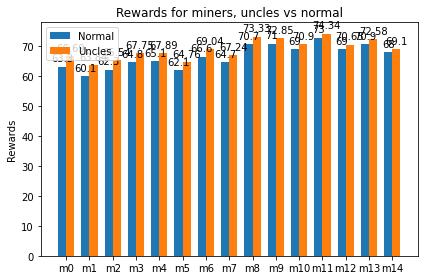

3.740849576707885
66.70666666666666
3.150667654111849
69.1


In [338]:

width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2,miner_rewards_normal,width, label="Normal")
uncles = ax.bar(xpos + width/2,miner_rewards_uncles,width, label="Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()

print(np.std(miner_rewards_normal))
print(np.average(miner_rewards_normal))
print(np.std(miner_rewards_uncles))
print(np.average(miner_rewards_uncles))

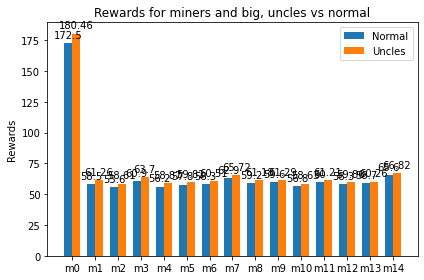

In [329]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2, miner_rewards_normal_big, width, label="Normal")
uncles = ax.bar(xpos + width/2, miner_rewards_uncles_big, width, label="Uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for miners and big, uncles vs normal")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()

In [330]:
# print(np.std(miner_rewards_normal))
# print(np.average(miner_rewards_normal))
# print(sum(miner_rewards_normal))

# print(np.std(miner_rewards_uncles))
# print(np.average(miner_rewards_uncles))
# print(sum(miner_rewards_uncles))
# ## Standard deviation for uncles is less than normal bc, aka more "fair"

### Testing unclerewards

To test uncle rewards we could employ many different ways of testing fairness, but we chose to do a...? Dunno what to write
-> show with code and plot what we mean. Numbers plot, whatever. Below we have run the application X times and the plot proves ... Code for uncles does not seem to work :((

### Static chain

In order to reliably test this, we decided that it was neccessary to implement a version of the blockchain without any randomness. This is achieved with the static parameter for the run method. Normally, the miners will pick randomly between block of the same height to mine on top of, but for the static chain, they will instead use their name to calculate an index (using the mod operator and sum(ord)) of their name) to select which block to mine on top of. 


In [331]:
bc, m, s = run(mining_power=40, num_blocks=8, static=True)
show(bc)

In [332]:
stats = get_stats(m, s)
print(stats)

  name  reward  uncle_reward  blocks  uncles  newphes  power
0   m0      10             0       1       0        0     40
1   m1       0             0       0       0        0     40
2   m2       0             0       0       0        0     40
3   m3      10             0       1       0        0     40
4   m4      10             0       1       0        0     40
5   m5      10             0       1       0        0     40
6   m6      10             0       1       0        0     40
7   m7      20             0       2       0        0     40
8   m8       0             0       0       0        0     40
9   m9      10             0       1       0        0     40


In [333]:
bc, m, s = run(mining_power=40, num_blocks=8, uncle_reward=3, nephew_reward=1, static=True)
show(bc)

In [334]:
stats = get_stats(m, s)
print(stats)

  name  reward  uncle_reward  blocks  uncles  newphes  power
0   m0      10             0       1       0        0     40
1   m1       0             3       0       1        0     40
2   m2       0             0       0       0        0     40
3   m3      10             0       1       0        0     40
4   m4      10             0       1       0        0     40
5   m5      10             0       1       0        0     40
6   m6      10             1       1       0        1     40
7   m7      20             4       2       1        1     40
8   m8       0             0       0       0        0     40
9   m9      10             0       1       0        0     40


In [335]:
bc, m, s = run(mining_power=40, num_blocks=30, uncle_reward=3, nephew_reward=1)
show(bc)

In [336]:
stats = get_stats(m, s)
print(stats)

  name  reward  uncle_reward  blocks  uncles  newphes  power
0   m0      10             9       1       3        0     40
1   m1      20             7       2       2        1     40
2   m2      20             0       2       0        0     40
3   m3      30             3       3       0        3     40
4   m4      10             6       1       2        0     40
5   m5      30             3       3       1        0     40
6   m6      60             5       6       1        2     40
7   m7      50             1       5       0        1     40
8   m8      20             3       2       0        3     40
9   m9      50             3       5       1        0     40


## Selfish mining

When a blockchain has implemented a uncle reward mechanism it eliminates some risk for the miners. When they mine a block that ends up outside the longest chain it will still be compensated somewhat for the time and energy put into the block, even if it is not on the level of the blockreward. However the blockchain may be more vulnerable to selfish mining attacks. Below you can see a model of a big miner on a uncle blockchain and a selfish miner on a uncle blockchain, where both of these have the same amount of _power_. So the difference is only how each of these miners behave. One of them will try to hide their blocks and one just publishes them. So if a uncle blockchain is more profitable to a selfish miner he should end up with more rewards than the big miner. 

In [339]:
miner_rewards_normal_selfish, miner_rewards_uncles_selfish = getavg(100,run,num_blocks=100,num_miners=14, uncle_reward=3, nephew_reward=2, num_selfish_miners=1, mining_power_selfish=30)

In [341]:
miner_rewards_normal_self_big, miner_rewards_uncles_self_big = getavg(100,run,num_blocks=100,num_miners=13, uncle_reward=3, nephew_reward=2,miners=[30], num_selfish_miners=1, mining_power_selfish=10)

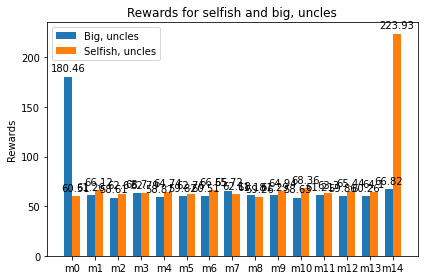

In [342]:
width = 0.35
xpos = np.arange(len(miner_names))

fig, ax = plt.subplots()
normal = ax.bar(xpos - width/2, miner_rewards_uncles_big, width, label="Big, uncles")
uncles = ax.bar(xpos + width/2, miner_rewards_uncles_selfish, width, label="Selfish, uncles")

ax.set_ylabel("Rewards")
ax.set_title("Rewards for selfish and big, uncles")
ax.set_xticks(xpos)
ax.set_xticklabels(miner_names)
ax.legend()
ax.bar_label(normal,padding=3)
ax.bar_label(uncles,padding=3)
fig.tight_layout()
plt.show()